In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [26]:
N = 500

def real_model(x):
    y = (torch.randn(1, N) + 2) * x + 3 + torch.randn(1, N)
    return y

x = torch.linspace(-3, 4, N).view(-1, 1)
y = real_model(x.squeeze()).view(-1, 1)

In [68]:
class NormalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.mean = None
        self.std = None

        k = 6

        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(1, k),
        )
        self.mean_layer = torch.nn.Linear(k, 1)
        self.std_layer = torch.nn.Sequential(
            torch.nn.Sigmoid(),
            torch.nn.Linear(k, 1),
            torch.nn.ELU()
        )

    def forward(self, x):
        h = self.hidden_layers(x)
        self.mean = self.mean_layer(h)
        self.std = self.std_layer(h) + 1

        return self.mean, self.std
    
    def __repr__(self):
        return f'Mean: {self.mean.item():.5f} and Std: {self.std.item():.5f}'


In [69]:
def k(mean, std, x):
    return 1 / np.sqrt(2 * np.pi) * torch.exp(-((x - mean)/std) ** 2 / 2) / std

def log_k(mean, std, y):
    return -torch.log(std) - (y - mean)**2 / (2 * std**2)

In [70]:
model = NormalModel()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [71]:
max_epoch = 5000
for epoch in range(max_epoch):
    opt.zero_grad()

    if epoch % 10 == 0 and max_epoch - epoch > 100:
        sample = torch.randint(N, (1, 100)).squeeze()
    elif max_epoch - epoch == 100:
        sample = torch.arange(0, N)

    mean, std = model(x[sample])
    log_likelyhood = log_k(mean, std, y[sample]).sum()
    loss = -log_likelyhood
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f'{epoch}:: Loss = {loss.item()}')
    


0:: Loss = 1322.6485595703125
100:: Loss = 127.76948547363281
200:: Loss = 113.21403503417969
300:: Loss = 120.94306182861328
400:: Loss = 115.87690734863281
500:: Loss = 122.68001556396484
600:: Loss = 122.27761840820312
700:: Loss = 125.66720581054688
800:: Loss = 102.8907470703125
900:: Loss = 124.40837860107422
1000:: Loss = 108.44560241699219
1100:: Loss = 128.66941833496094
1200:: Loss = 115.2510986328125
1300:: Loss = 117.05230712890625
1400:: Loss = 107.15065002441406
1500:: Loss = 110.51656341552734
1600:: Loss = 117.69493103027344
1700:: Loss = 118.49095916748047
1800:: Loss = 122.29779052734375
1900:: Loss = 115.76141357421875
2000:: Loss = 116.54133605957031
2100:: Loss = 100.65702056884766
2200:: Loss = 107.24303436279297
2300:: Loss = 124.50273132324219
2400:: Loss = 97.36341857910156
2500:: Loss = 113.57903289794922
2600:: Loss = 114.22251892089844
2700:: Loss = 116.51419067382812
2800:: Loss = 111.8222885131836
2900:: Loss = 117.4985580444336
3000:: Loss = 115.252487182

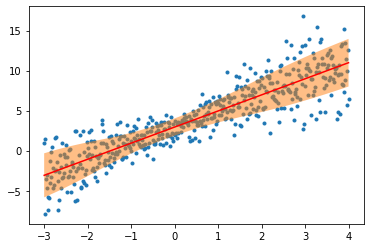

In [72]:
m, s = model(x)

plt.scatter(x, y, marker='.')
plt.plot(x, m.detach(), 'r')
plt.fill_between(x.squeeze(), (m.detach()-s.detach()).squeeze(), (m.detach()+s.detach()).squeeze(), alpha=0.5)

In [73]:
x.size(), y.size()

(torch.Size([500, 1]), torch.Size([500, 1]))

In [74]:
def check_within_two_stddeviations(x, y):
    y_pred, y_std = model(x)
    # want 95.6% inside 
    a = (y - y_pred).abs() / y_std
    hits = (a <= 2).sum()
    return hits / len(x)

In [75]:
check_within_two_stddeviations(x, y) - 0.956

tensor(-0.0060)

In [76]:
np.sqrt(0.96 * 0.04 / N)

0.008763560920082658